In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

from qiskit import(
    QuantumCircuit,
    ClassicalRegister, 
    QuantumRegister,
    transpile)

from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import Statevector

from qiskit.providers.basic_provider import BasicProvider
# from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate, ZZGate

# backend = BasicProvider().get_backend('basic_simulator')
# provider = IonQProvider()

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2
backend = AerSimulator.from_backend(FakeWashingtonV2())

# backend_native = provider.get_backend("simulator", gateset='native')

from givens_angles import *

In [2]:
x = np.array([[0, 1], [1, 0]], dtype='complex')
y = np.array([[0, -1j], [1j, 0]], dtype='complex')
Id = np.identity(2)
op = np.kron(Id, x) @ np.kron(y, Id) - np.kron(Id, y) @ np.kron(x, Id)

def givens_circ(theta):
    mat = LA.expm(1j/2 * theta * op)
    qreg = QuantumRegister(2)
    circ = QuantumCircuit(2)
    circ.append(UnitaryGate(mat), [0, 1])
    return circ

In [3]:
N_s = 8
N_t = 1
J = 0.4
h = 1
g = 0.3
dt = 0.6
N_t * dt

0.6

In [4]:
def build_op(N_s, site, op):
    Op = np.identity(1)
    for s in range(N_s):
        if s == site:
            Op = np.kron(Op, op)
        else:
            Op = np.kron(Op, np.identity(2))
    return Op

x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
n = np.array([[0, 0], [0, 1]])
sm = (x - 1j * y) / 2

X = []
Z = []
N = []
Sm = []

for i in range(N_s):
    X.append(build_op(N_s, i, x))
    Z.append(build_op(N_s, i, z))
    N.append(build_op(N_s, i, n))
    Sm.append(build_op(N_s, i, sm))

H_XX = np.zeros((2**N_s, 2**N_s), dtype=complex)
H_Z = np.zeros((2**N_s, 2**N_s), dtype=complex)
H_ZZ = np.zeros((2**N_s, 2**N_s), dtype=complex)

for j in range(N_s):
    H_XX -= J * X[j] @ X[(j + 1) % N_s]
    H_Z -= h * Z[j]
    H_ZZ -= g * Z[j] @ Z[(j + 1) % N_s]

TEO = LA.expm(-1j * dt * H_Z) @ LA.expm(-1j * dt * H_XX) @ LA.expm(-1j * dt * H_ZZ)

H = H_XX + H_Z + H_ZZ
Evals, Evecs = np.linalg.eigh(H)
ground_state = Evecs[:,0]

In [5]:
n_k = 3
sigma = 3/2
# Finds Givens Angles for givens N_s, n_s (if localized),
# mean position x, mean momentum number (integer), and width.
# From givens_angles.py
# r = [-1, 0, 1, 2]
betas_r, angles_r = giv_angles(N_s, N_s, 1, n_k, sigma, r=None)
betas_l, angles_l = giv_angles(N_s, N_s, 5, -n_k, sigma, r=None)

[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j -0.+0.j  0.+0.j]
[ 1.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.-0.j  0.-0.j]


In [6]:
vqe_angles = np.load('vqe-thetas-N8-J0.4-h1-g0.3.npy')

In [7]:
def make_circuit(t_step):
    qreg = QuantumRegister(N_s+4)
    creg = ClassicalRegister(N_s+4)
    circ = QuantumCircuit(qreg, creg)

    # State-Prep
    ## Ground state preparation
    # circ.prepare_state(ground_state, range(N_s)) # Exact
    ## VQE
    for i in range(N_s):
        circ.ry(vqe_angles[i], i)
        circ.rz(vqe_angles[N_s + i], i)

    for i in range(2, len(vqe_angles)//N_s-1,2):    
        for j in range(N_s-1):
            k = N_s - 1 - j
            circ.cx(k-1, k)
        for j in range(N_s):
            circ.ry(vqe_angles[i * N_s + j], j)
            circ.rz(vqe_angles[(i+1) * N_s + j], j)

    circ.x(N_s) # Prepare control
    circ.x(N_s+2) # Prepare control

    ## Right moving wave packet
    ### V^dag
    for i in range(N_s):
        circ.rz(betas_r[i], i)
    for i in range(N_s-1):
        j = N_s - 1 - i
        circ.append(givens_circ(angles_r[i]), [j-1, j])
    ###
    circ.ccx(N_s, 0, N_s+1) # Remove |1> part of system qubit
    circ.x(0) # Excite system qubit
    ### V
    for i in range(N_s-1):
        j = N_s - 2 - i
        circ.append(givens_circ(-angles_r[j]), [i, i+1])
    for i in range(N_s):
        circ.rz(-betas_r[i], i)
    
    # # Left Moving Wave Packet
    # # V^dag
    for i in range(N_s):
        circ.rz(betas_l[i], i)
    for i in range(N_s-1):
        j = N_s - 1 - i
        circ.append(givens_circ(angles_l[i]), [j-1, j])
    ###
    circ.ccx(N_s+2, 0, N_s+3) # Remove |1> part of system qubit
    # for i in range(N_s//2): # Obey anticommutation relations
    #     circ.z(i)
    circ.x(0) # Excite system qubit
    ### V
    for i in range(N_s-1):
        j = N_s - 2 - i
        circ.append(givens_circ(-angles_l[j]), [i, i+1])
    for i in range(N_s):
        circ.rz(-betas_l[i], i)
    
    # Trotter Evolution
    for i in range(t_step):
        # Transverse Field
        for j in range(N_s):
            circ.rz(-2 * h * dt, j)
        # Nearest-neighbor
        for j in range(N_s):
            circ.rxx(-2 * J * dt, j, (j + 1) % N_s)
        # Longitudinal Field
        for j in range(N_s):
            circ.rzz(-2 * g * dt, j, (j + 1) % N_s)
    
    # Measure
    circ.measure(qreg, creg[::-1])

    # new_circuit = transpile(circ, backend, 
    #                     basis_gates=['cx', 'id', 'rz', 'x', 'sx'], 
    #                     optimization_level=3)

    return circ

In [8]:
basis_gates = ['cz', 'rx', 'rz', 'rzz', 'sx', 'x']

circuits = []
gates = []
depths = []
for i in range(N_t):
    circuit = make_circuit(i)
    new_circuit = transpile(circuit, backend=backend, optimization_level=3)
    circuits.append(new_circuit)
    gates.append(dict(new_circuit.count_ops()))
    depths.append(new_circuit.depth())
    

In [9]:
depths

[291]

In [10]:
gates

[{'rz': 235, 'sx': 181, 'cx': 81, 'measure': 12, 'x': 6}]

In [12]:
num_shots = 100000
job = backend.run(circuits, shots=num_shots)
counts_list = job.result().get_counts()

In [13]:
len(counts_list)

1656

In [14]:
# filename = 'qsim-free-Ns' + str(N_s)
# # filename = 'ionq-run-Feb10-Ns' + str(N_s)
# filename += '-lam' + str(lam)
# filename += '-eps' + str(hL)
# filename += '-dt' + str(dt)
# filename += '-shots' + str(num_shots)
# filename += '.json'

# import json
# with open(filename, 'w') as fout:
#     json.dump(counts_list, fout)

In [15]:
counts_list

{'000110111110': 1,
 '101100101110': 1,
 '000011101011': 1,
 '100101111000': 1,
 '110110011011': 1,
 '101000110111': 1,
 '001100111110': 1,
 '000011100110': 1,
 '000110011001': 1,
 '000101111011': 1,
 '011101001111': 1,
 '110111111010': 1,
 '111100100011': 1,
 '001101111110': 2,
 '100101000011': 1,
 '110000011111': 2,
 '000101100110': 1,
 '000100011100': 1,
 '010111111011': 1,
 '011100001111': 1,
 '011110101000': 1,
 '110011100010': 1,
 '010110101000': 1,
 '000001101000': 1,
 '010000001101': 1,
 '001011111011': 2,
 '111001111011': 1,
 '011001011001': 1,
 '010100000000': 1,
 '100011111011': 1,
 '100101110010': 1,
 '100010110110': 1,
 '011001100011': 1,
 '001000110101': 1,
 '000000010110': 2,
 '010011101010': 183,
 '011000011001': 2,
 '011011011110': 1,
 '101011101011': 1,
 '101000011101': 1,
 '000001111111': 1,
 '001110001111': 2,
 '001000010110': 1,
 '001001101111': 2,
 '101100000110': 1,
 '100010101100': 1,
 '011010101010': 34,
 '000110010110': 1,
 '001010001100': 5,
 '011100101110': 

In [16]:
counts_list = [counts_list]
qc_occ_nums = []
for i in range(N_t):
    expecz = np.zeros(N_s)
    num_anc_0 = 0
    for key in counts_list[i]:
        if key[N_s+1] == '0' and key[N_s+3] == '0':
            num_anc_0 += counts_list[i][key]
            for j in range(N_s):
                if key[j] == '0':
                    expecz[j] += counts_list[i][key]
                else:
                    expecz[j] -= counts_list[i][key]
    qc_occ_nums.append((1 - expecz/num_anc_0) / 2)
qc_occ_nums = np.array(qc_occ_nums)

Text(0.5, 1.0, '(a) Initial State')

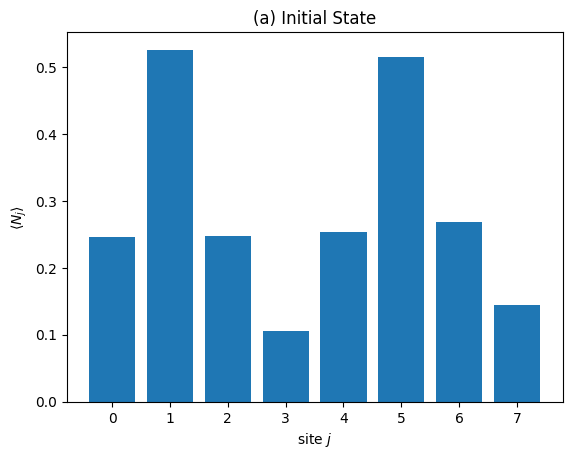

In [17]:
plt.bar(range(N_s), qc_occ_nums[0])
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
plt.title("(a) Initial State")

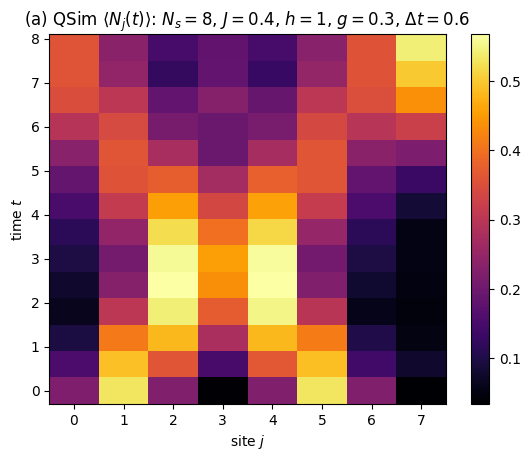

In [99]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, qc_occ_nums, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(a) QSim $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

<BarContainer object of 8 artists>

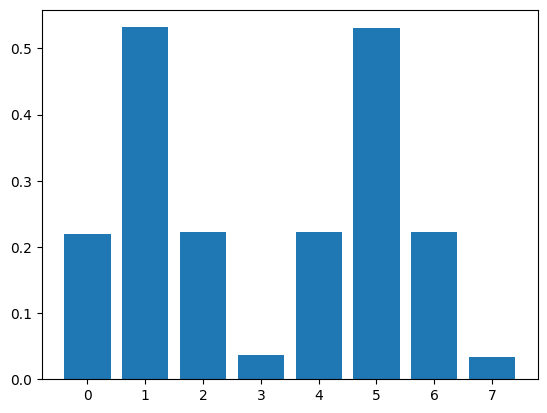

In [100]:
plt.bar(range(N_s), qc_occ_nums[0])

# Larger systems'

In [101]:
exact_occs = np.loadtxt("ising-approx-occs-N_s12-J0.4-h1-g0.3-width1.5-dt0.6.txt", dtype=float)

In [102]:
exact_occs.shape

(15, 12)

TypeError: Dimensions of C (15, 12) should be one smaller than X(8) and Y(14) while using shading='flat' see help(pcolormesh)

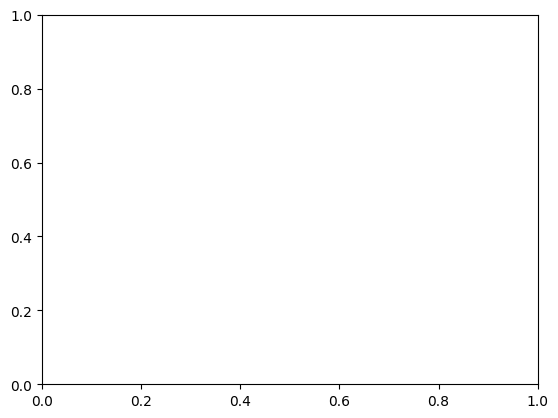

In [103]:
plt.pcolormesh(X, Y, exact_occs, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(a) QSim $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()

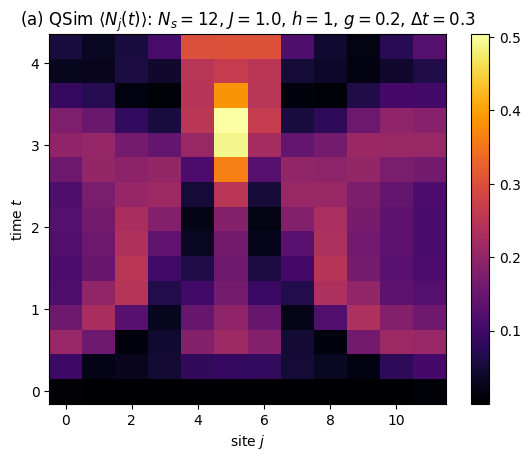

In [340]:
plt.pcolormesh(X, Y, np.abs(exact_occs - qc_occ_nums), cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(a) QSim $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()

In [341]:
np.mean(np.abs(exact_occs - qc_occ_nums))

0.13212111247685732

In [120]:
# for i in range(N_t):
#     plt.bar(range(N_s), qc_occ_nums[i], label='Exact Trotter', color='gray')
#     plt.xlabel('s (site)')
#     plt.ylabel(r'$\langle n_s \rangle$')
#     plt.legend()
#     plt.ylim(0,1.3)
#     title = r'$N_s =$' + str(N_s)
#     title += r', $\lambda$ = ' + str(lam)
#     title += r', $t = $' + str(round(i * dt, 4))
#     plt.title(title)
#     folder = 'qc-scattering-plots/'
#     filename = folder
#     filename += 'scatt-timestep' + str(i) + '.png'
#     plt.savefig(filename)
#     plt.close()

# Exact Diagonalization

In [18]:
CDAG = []
for s in range(N_s):
    cdag = Sm[s]
    for j in range(s):
        cdag = -Z[j] @ cdag
    CDAG.append(cdag)

In [24]:
r = np.array([-1, 0, 1, 2, 3, 4, -3, -2])
l = np.roll(r, 4)
def GWP_coeff(x, x_mean, x_dif, nk_mean, sig_k):
    k = nk_mean * np.pi / N_s
    coeff = 1 / np.sqrt(N_s) * np.exp(-1j * k * (x + x_mean))
    coeff *= np.exp(-x_dif[x]**2 / sig_k**2)
    return coeff

In [27]:
xr_mean = 1
xl_mean = 5
nk_mean = 3
sig_k = 3/2
rm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
lm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
for j in range(N_s):
    rm_op += GWP_coeff(j, 1, r, nk_mean, sig_k) * CDAG[j]
    lm_op += GWP_coeff(j, 5, l, -nk_mean, sig_k) * CDAG[j]

exact_init_state = np.zeros((2**N_s), dtype=complex)
exact_init_state[0] = 1
exact_init_state = lm_op @ rm_op @ ground_state
exact_init_state /= np.linalg.norm(exact_init_state)

In [28]:
state = np.array(exact_init_state)
occs = []
for t in range(N_t):
    occ = []
    for j in range(N_s):
        occ_j = np.inner(state.conjugate(), N[j] @ state)
        occ.append(occ_j)
    occs.append(np.real(occ))
    state = TEO @ state

Text(0.5, 1.0, 'Initial State: $N_s = $8, $n_k = \\pm$3, $\\sigma_k=$1.5')

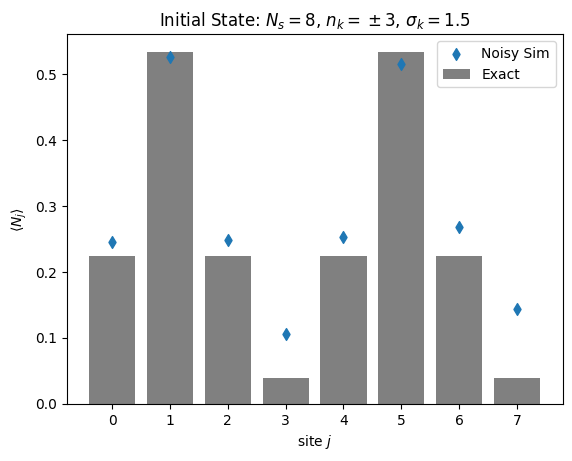

In [29]:
plt.bar(range(N_s), occs[0], color='grey', label='Exact')
plt.scatter(range(N_s), qc_occ_nums[0], marker='d', label='Noisy Sim')
plt.legend()
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
title = r'Initial State: '
title += r'$N_s = $' + str(N_s)
title += r', $n_k = \pm$' + str(nk_mean)
title += r', $\sigma_k=$' + str(sig_k)
plt.title(title)

In [30]:
perc_errors = []
for i in range(N_s):
    err = np.abs(1 - qc_occ_nums[0][i]/occs[0][i]) * 100
    perc_errors.append(err)
np.mean(perc_errors)

62.4885013720652

In [31]:
perc_errors

[9.778957002719956,
 1.4904049097782868,
 10.714051297525874,
 171.16742768104146,
 13.196504008736753,
 3.4177564078247014,
 20.020465945832267,
 270.12244372306225]

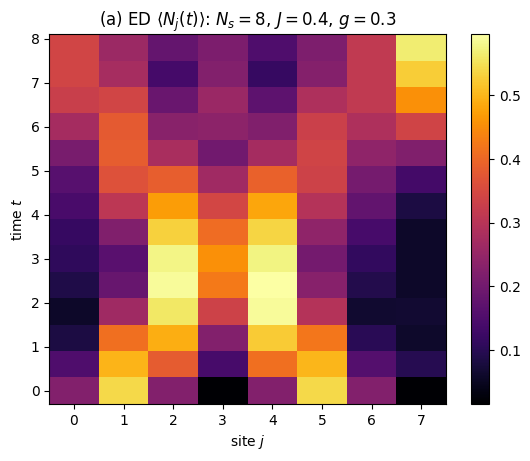

In [110]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, occs, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(a) ED $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
# title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

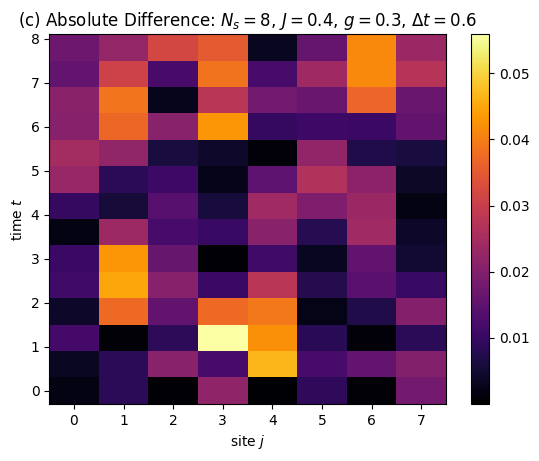

In [114]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

perc_errors = []
for t in range(N_t):
    perc_error_t = []
    for j in range(N_s):
        perc_error = np.abs((qc_occ_nums[t][j] - occs[t][j]))
        perc_error_t.append(perc_error)
    perc_errors.append(perc_error_t)

plt.pcolormesh(X, Y, perc_errors, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(c) Absolute Difference: $N_s = $' + str(N_s)
title += r', $J = $' + str(J)
# title += r', $h = $' + str(h)
title += r', $g = $' + str(g)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

In [115]:
np.mean(perc_errors)

np.float64(0.016967739496864472)

In [116]:
nks = np.arange(-N_s + 1, N_s + 1, 2)

In [77]:
ETADAG8 = []
for i in range(N_s):
    eta = np.zeros((2**N_s, 2**N_s), dtype=complex)
    for j in range(N_s):
        arg = 1 / np.sqrt(N_s) * np.exp(-1j * nks[i] * np.pi / N_s * j)
        eta += arg * CDAG[j]
    eta /= np.linalg.norm(eta)
    ETADAG8.append(eta)

In [78]:
ETADAG12 = []
for i in range(N_s):
    eta = ETADAG8[i]
    eta = np.kron(np.identity(2**4, dtype=complex), eta)
    eta /= np.linalg.norm(eta)
    ETADAG12.append(eta)

In [79]:
from qiskit.quantum_info import Statevector
qreg = QuantumRegister(N_s+4)
circ = QuantumCircuit(qreg)

# State-Prep
## Ground state preparation
circ.prepare_state(ground_state, range(N_s)) # Exact
ground_state12 = Statevector.from_instruction(circ).reverse_qargs().data

circ.x(N_s) # Prepare control
circ.x(N_s+2) # Prepare control

## Right moving wave packet
### V^dag
for i in range(N_s//2):
    circ.rz(betas_r[i], i)
for i in range(N_s//2-1):
    j = N_s//2 - 1 - i
    circ.append(givens_circ(angles_r[i]), [j-1, j])
###
circ.ccx(N_s, 0, N_s+1) # Remove |1> part of system qubit
circ.x(0) # Excite system qubit
### V
for i in range(N_s//2-1):
    j = N_s//2 - 2 - i
    circ.append(givens_circ(-angles_r[j]), [i, i+1])
for i in range(N_s//2):
    circ.rz(-betas_r[i], i)

# # Left Moving Wave Packet
# # V^dag
for i in range(N_s//2):
    circ.rz(betas_l[i], i+N_s//2)
for i in range(N_s//2-1):
    j = N_s - 1 - i
    circ.append(givens_circ(angles_l[i]), [j-1, j])
###
circ.ccx(N_s+2, N_s//2, N_s+3) # Remove |1> part of system qubit
for i in range(N_s//2): # Obey anticommutation relations
    circ.z(i)
circ.x(N_s//2) # Excite system qubit
### V
for i in range(N_s//2-1):
    j = N_s//2 - 2 - i
    circ.append(givens_circ(-angles_l[j]), [i+N_s//2, i+N_s//2+1])
for i in range(N_s//2):
    circ.rz(-betas_l[i], i+N_s//2)

state = Statevector.from_instruction(circ).reverse_qargs().data

In [80]:
ground_state_12 = ground_state12.reshape((2**12))
state = state.reshape((2**12))

In [87]:
four_spec_8 = []
four_spec_12 = []
for i in range(N_s-1):
    for j in range(i+1, N_s):
        k_state8 = ETADAG8[i] @ ETADAG8[j] @ ground_state
        k_state8 /= np.linalg.norm(k_state8)
        # k_state12 = ETADAG12[i] @ ETADAG12[j] @ ground_state_12
        # k_state12 /= np.linalg.norm(k_state12)
        
        amp8 = np.inner(k_state8.conj(), exact_init_state)
        # amp12 = np.inner(k_state12.conj(), state)

        four_spec_8.append(amp8 * amp8.conj())
        # four_spec_12.append(amp12 * amp12.conj())

In [88]:
four_spec_12

[]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


<BarContainer object of 0 artists>

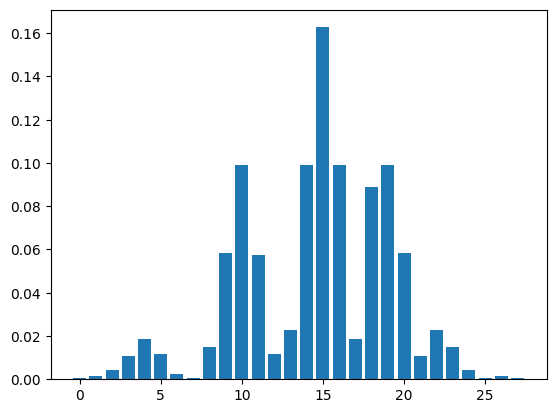

In [89]:
plt.bar(range(len(four_spec_8)), four_spec_8)
plt.bar(range(len(four_spec_12)), four_spec_12)

In [85]:
np.sum(four_spec_8)

(5.8845586355845466e-05+0j)